In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm

In [3]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.40', '1.0.1.post2')

In [3]:
torch.cuda.set_device(0)

In [4]:
path = Path('/home/anurag/practice/nlp-for-urdu/language-model')

In [5]:
p = path.glob('UrduWikipediaArticles/*')
files = [x for x in p if x.is_file()]

In [6]:
len(files)

153814

In [7]:
train_files, test_files = train_test_split(files, test_size=0.3,random_state=2019)

In [8]:
len(train_files), len(test_files)

(107669, 46145)

In [9]:
train_files[0]

PosixPath('/home/anurag/practice/nlp-for-urdu/language-model/UrduWikipediaArticles/222953.pkl')

In [10]:
str(train_files[0]).split('/')[-1][:-4]

'222953'

In [11]:
# Preparing dataset for fastai
for file in train_files:
    with open(file, 'rb') as f:
        text = pickle.load(f)
    with open(path/'UrduDataset'/'train'/(str(file).split('/')[-1][:-4]+'.txt'), "w") as text_file:
        text_file.write(text)

In [12]:
for file in test_files:
    with open(file, 'rb') as f:
        text = pickle.load(f)
    with open(path/'UrduDataset'/'valid'/(str(file).split('/')[-1][:-4]+'.txt'), "w") as text_file:
        text_file.write(text)

In [4]:
class UrduTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/urdu_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [5]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/urdu_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(30000)]

In [6]:
urdu_vocab = Vocab(itos)

In [7]:
tokenizer = Tokenizer(tok_func=UrduTokenizer, lang='ur')

In [8]:
tokenizer.special_cases

['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep']

In [9]:
data_lm = TextLMDataBunch.from_folder(path=path/'UrduDataset', tokenizer=tokenizer, vocab=urdu_vocab)

In [10]:
data_lm.save()

In [4]:
data_lm = TextLMDataBunch.load(path=path/'UrduDataset')

In [5]:
data_lm.show_batch()

idx,text
0,"▁ xx bo s ▁رینڈولف ▁کاؤنٹی ، ▁الاباما ▁ریاستہائے ▁متحدہ ▁امریکا ▁کا ▁ایک ▁رہائشی ▁علاقہ ▁جو ▁الاباما ▁میں ▁واقع ▁ہے۔ ▁رینڈولف ▁کاؤنٹی ، ▁الاباما ▁کا ▁رقبہ ▁1 ,512 .56 ▁مربع ▁کیلومیٹر ▁ہے ، ▁ہے۔ ▁کی ▁مجموع ی ▁آبادی ▁ xx bo s ▁ xx bo s ▁ریاستہائے ▁متحدہ ▁امریکا ▁کی ▁ریاست ▁نیویارک ▁کی ▁ایک ▁کاؤنٹی - ▁ xx bo s ▁حب ق وق ▁انبیائے ▁بنی ▁اسرائیل ▁میں ▁سے ▁ایک ▁نبی"
1,▁بنجر ▁زمینوں ▁پر ▁نمو ▁پاتا ▁ہے۔ ▁اس ▁کا ▁ تنا ▁بوتل ▁نما ▁ہوتا ▁ہے ▁جس ▁میں ▁بڑی ▁مقدار ▁میں ▁پانی ▁جمع ▁رہتا ▁ہے۔ ▁ایک ▁اندازے ▁کے ▁مطابق ▁اس ▁درخت ▁کے ▁ تنے ▁میں ▁ایک ▁لاکھ ▁بیس ▁ہزار ▁لیٹر ▁پانی ▁جمع ▁کرنے ▁کی ▁گنجائش ▁ہوتی ▁ہے ، ▁جو ▁اس ▁بنجر ▁علاقے ▁میں ▁انسانوں ▁اور ▁جنگلی ▁حیات ▁کے ▁لیے ▁زندگی ▁کی ▁علامت ▁سمجھا ▁جاتا ▁ہے۔ ▁اس ▁درخت ▁کی ▁ایک ▁اور ▁بات ▁جو
2,▁مضمون ▁ملاحظ ہ ▁ہو : ▁م َّ ا ▁خ َ ل ْ ق ُ ك ُ م ْ ▁و َ ل َ ا ▁ب َ ع ْ ث ُ ك ُ م ْ ▁إ ِ ل َّ ا ▁ك َ ن َ ف ْ س ٍ ▁و َ اح ِ د َ ة ٍ ▁۔۔۔ تم ▁سارے ▁انسانوں ▁کو پیدا ▁کرنا اور ▁پھر ▁دوبارہ ▁زندگی ▁بخش نا ▁تو ▁بس ▁ایسا
3,▁اس ▁کے ▁بعد ▁ایک ▁ہزار ▁سات ▁سو ▁تریانوے ▁یا ▁سترہ ▁سو ▁تریانوے ▁بولا ▁جاتا ▁ہے۔ ▁ xx bo s ▁محافظہ ▁قل قی لیہ ▁فلسطین ▁کے ▁سولہ ▁محافظ ات ▁میں ▁سے ▁ایک ▁ہے ، ▁جو ▁مغربی ▁کنارہ ▁میں ▁واقع ▁ہے۔ ▁ xx bo s ▁مملکت ▁ھو ل ندا ▁ایک ▁خود ▁مختار ▁ریاست ▁اور ▁آئینی ▁بادشاہت ▁ہے ▁کو ▁کہ ▁مغربی ▁یورپ ▁کے ▁ساتھ ▁کیریبین ▁میں ▁پھیلی ▁ہوئی ▁ہے۔ ▁مملکت ▁نیدرلینڈز ▁اس ▁وقت
4,▁متن ▁· ▁انگریزی ▁ترجمہ ▁قرآن ▁مجید ▁کی ▁41 ▁ویں ▁سورت ▁جو ▁سو رۂ ▁ف ُ ص ّ ِ ل َ ت ▁بھی ▁کہلاتی ▁ہے۔ ▁اس ▁میں ▁54 ▁آیات ▁اور ▁6 ▁رکوع ▁ہیں۔ ▁اس ▁سورت ▁کا ▁نام ▁دو ▁لفظ وں ▁سے ▁مرکب ▁ہے ▁ایک ▁ح ٰ م ▁دوسرے ▁السجد ہ ▁مطلب ▁یہ ▁ہے ▁کہ ▁وہ ▁سورت ▁جس ▁کا ▁آغاز ▁ح ٰ م ▁سے ▁ہوتا ▁ہے ▁اور ▁جس ▁میں ▁ایک ▁مقام ▁پر


In [6]:
len(data_lm.vocab.itos)

30000

In [7]:
learn = language_model_learner(data_lm, drop_mult=0.3)

In [8]:
gc.collect()

0

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


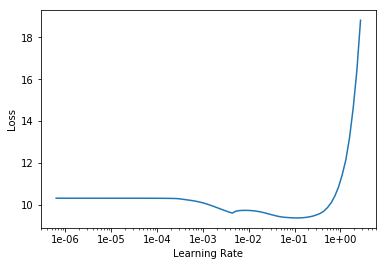

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.851694,3.756488,0.363578


In [17]:
learn.save('first', with_opt=True)

In [18]:
learn.load('first', with_opt=True);

In [9]:
learn.unfreeze()

In [20]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.756290,3.822223,0.353836
2,3.685229,3.799644,0.352893
3,3.589541,3.521406,0.385709
4,3.166971,3.220029,0.428290
5,3.149071,3.101883,0.447893


In [21]:
learn.save('second-ur-lm', with_opt=True)

In [10]:
learn.load('second-ur-lm', with_opt=True);

In [11]:
learn.fit_one_cycle(30, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,2.928500,3.092237,0.449652
2,3.040899,3.080851,0.451736
3,2.966673,3.068852,0.454310
4,3.010943,3.046978,0.458104
5,2.881997,3.021647,0.462656
6,2.825207,2.996819,0.467186
7,2.938460,2.970946,0.471994
8,2.938644,2.940169,0.477906
9,2.873854,2.917158,0.482316
10,2.932488,2.889037,0.487278


In [12]:
learn.save('third-ur-lm', with_opt=True)

In [13]:
learn.load('third-ur-lm', with_opt=True);

In [14]:
learn.fit_one_cycle(10, 1e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,2.373808,2.593668,0.544237
2,2.236325,2.592030,0.544580
3,2.412799,2.592942,0.544528
4,2.393425,2.588914,0.545238
5,2.239298,2.586825,0.545738
6,2.450857,2.584988,0.546140
7,2.385140,2.583483,0.546425
8,2.526998,2.581815,0.546879
9,2.255459,2.580998,0.547135
10,2.494641,2.580521,0.547101


In [15]:
learn.save('fourth-ur-lm', with_opt=True)

In [9]:
learn.load('fourth-ur-lm',with_opt=True);

In [14]:
TEXT = "میں کروں گا"
N_WORDS = 40
N_SENTENCES = 2

In [15]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.9) for _ in range(N_SENTENCES)))

میں کروں گا ؤ ی ▁اور ھا ▁ ے ▁ ، ▁ہم اح ▁ ، ▁ ی ه ▁ ہ ي ▁ي ▁چنے ▁ش َّ و ِ ی ▁ ، ▁ث ِ ی نو ▁ ، ▁اب و َ ▁ ، ▁اش َّ
میں کروں گا ، ▁ہو ▁ ی ، ▁ ین کا ، ▁ یات سکو ، ▁ ونکس ، ▁ نگ جو نٹ ، ▁ سیکس ، ▁ ▁جک ▁الحشر ج ، ▁ سٹر ه د ▁کرو ، ▁ سٹر نٹ ▁اور ▁”


In [16]:
np.exp(2.58)

13.197138159658358